# Importing libries that we will need 

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# List of columns that are not useful 

In [0]:
column_to_drop = ["RefId","PurchDate","Auction","VehYear",
                  "Trim","SubModel","Color","WheelType",
                  "Nationality","TopThreeAmericanName",
                  "MMRAcquisitionAuctionCleanPrice",
                  "MMRAcquisitionRetailAveragePrice",
                  "MMRAcquisitonRetailCleanPrice",
                  "MMRCurrentAuctionCleanPrice","WheelTypeID",
                  "MMRCurrentRetailAveragePrice","VNZIP1",
                  "MMRCurrentRetailCleanPrice","PRIMEUNIT",
                  "AUCGUART","BYRNO","VNST","IsOnlineSale","Model"]

In [0]:
#upload data
from google.colab import files
uploaded = files.upload()

In [0]:
df = pd.read_csv("training.csv")

In [0]:
df = df.drop(columns= column_to_drop)

In [0]:
df = df.dropna()

In [0]:
df.MMRCurrentAuctionAveragePrice = df.MMRCurrentAuctionAveragePrice.replace(0,df.MMRCurrentAuctionAveragePrice.mean())

df.VehBCost = df.VehBCost.replace(0,df.VehBCost.mean())

df.drop(df[df.VehBCost <= 2000].index, inplace = True) 

df.drop(df[df.VehBCost >= 13000].index, inplace = True) 

df.drop(df[df.MMRAcquisitionAuctionAveragePrice <= 1500].index, inplace = True)

df.drop(df[df.MMRAcquisitionAuctionAveragePrice <= 2000].index, inplace = True)

df.drop(df[df.MMRCurrentAuctionAveragePrice <= 1800].index, inplace = True)

df.drop(df[df.MMRCurrentAuctionAveragePrice >= 15000].index, inplace = True)

df.Transmission = df.Transmission.str.upper()

In [0]:
df.to_csv("only_number_now.csv")

In [93]:
df.describe(include='all')

,IsBadBuy,VehicleAge,Make,Transmission,VehOdo,Size,MMRAcquisitionAuctionAveragePrice,MMRCurrentAuctionAveragePrice,VehBCost,WarrantyCost
count,56753.000000,56753.000000,56753,56753,56753.000000,56753,56753.000000,56753.000000,56753.000000,56753.000000
unique,NaN,NaN,31,2,NaN,12,NaN,NaN,NaN,NaN
top,NaN,NaN,CHEVROLET,AUTO,NaN,MEDIUM,NaN,NaN,NaN,NaN
freq,NaN,NaN,13580,54781,NaN,23984,NaN,NaN,NaN,NaN
mean,0.121315,4.145243,NaN,NaN,71449.964724,NaN,6223.016175,6199.423112,6749.401664,1272.407697
std,0.326496,1.681420,NaN,NaN,14536.883938,NaN,2303.769659,2306.334750,1714.741249,591.985963
min,0.000000,0.000000,NaN,NaN,5368.000000,NaN,2001.000000,1801.000000,2060.000000,462.000000
25%,0.000000,3.000000,NaN,NaN,61776.000000,NaN,4398.000000,4367.000000,5475.000000,837.000000
50%,0.000000,4.000000,NaN,NaN,73307.000000,NaN,6168.000000,6120.000000,6730.000000,1155.000000
75%,0.000000,5.000000,NaN,NaN,82366.000000,NaN,7788.000000,7757.000000,7900.000000,1623.000000


### Classification Preprocessing

Feature Reshaping

In [0]:
from sklearn.preprocessing import LabelEncoder

Now we will trasform the columns below into catogories 

Make Transmission Size

In [0]:
label_encoders = dict()
column2encode = ['Make', 'Transmission','Size']

In [0]:
for col in column2encode:
    le = LabelEncoder()
    df.loc[:,col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [97]:
df.head()

,IsBadBuy,VehicleAge,Make,Transmission,VehOdo,Size,MMRAcquisitionAuctionAveragePrice,MMRCurrentAuctionAveragePrice,VehBCost,WarrantyCost
0,1,2,13,0,61184,5,6796.0,6628.0,6100.0,533
1,0,3,5,0,92383,5,5480.0,5480.0,4000.0,1630
2,0,2,5,0,45965,5,8067.0,7497.0,7500.0,693
3,0,4,6,0,80169,11,4817.0,4817.0,4725.0,1633
4,0,4,4,0,77372,11,5430.0,5370.0,5670.0,1623


In [98]:


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56753 entries, 0 to 58384
Data columns (total 10 columns):
IsBadBuy                             56753 non-null int64
VehicleAge                           56753 non-null int64
Make                                 56753 non-null int64
Transmission                         56753 non-null int64
VehOdo                               56753 non-null int64
Size                                 56753 non-null int64
MMRAcquisitionAuctionAveragePrice    56753 non-null float64
MMRCurrentAuctionAveragePrice        56753 non-null float64
VehBCost                             56753 non-null float64
WarrantyCost                         56753 non-null int64
dtypes: float64(3), int64(7)
memory usage: 4.8 MB


In [99]:
df.describe(include="all")

,IsBadBuy,VehicleAge,Make,Transmission,VehOdo,Size,MMRAcquisitionAuctionAveragePrice,MMRCurrentAuctionAveragePrice,VehBCost,WarrantyCost
count,56753.000000,56753.000000,56753.000000,56753.000000,56753.000000,56753.000000,56753.000000,56753.000000,56753.000000,56753.000000
mean,0.121315,4.145243,8.430057,0.034747,71449.964724,4.806460,6223.016175,6199.423112,6749.401664,1272.407697
std,0.326496,1.681420,7.165837,0.183140,14536.883938,2.806174,2303.769659,2306.334750,1714.741249,591.985963
min,0.000000,0.000000,0.000000,0.000000,5368.000000,0.000000,2001.000000,1801.000000,2060.000000,462.000000
25%,0.000000,3.000000,4.000000,0.000000,61776.000000,3.000000,4398.000000,4367.000000,5475.000000,837.000000
50%,0.000000,4.000000,5.000000,0.000000,73307.000000,5.000000,6168.000000,6120.000000,6730.000000,1155.000000
75%,0.000000,5.000000,12.000000,0.000000,82366.000000,6.000000,7788.000000,7757.000000,7900.000000,1623.000000
max,1.000000,9.000000,30.000000,1.000000,115717.000000,11.000000,19250.000000,14995.000000,12590.000000,7498.000000


Train/Test partitioning

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
attributes = [col for col in df.columns if col != 'IsBadBuy']
X = df[attributes].values
y = df['IsBadBuy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

### Parameter Tuning

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [0]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [104]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
             }

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=100)
random_search.fit(X, y)
report(random_search.cv_results_, n_top=3)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 0.879 (std: 0.000)
Parameters: {'min_samples_split': 30, 'min_samples_leaf': 50, 'max_depth': 6}

Model with rank: 2
Mean validation score: 0.879 (std: 0.000)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 100, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.879 (std: 0.000)
Parameters: {'min_samples_split': 30, 'min_samples_leaf': 100, 'max_depth': 3}

Model with rank: 2
Mean validation score: 0.879 (std: 0.000)
Parameters: {'min_samples_split': 100, 'min_samples_leaf': 100, 'max_depth': 13}

Model with rank: 2
Mean validation score: 0.879 (std: 0.000)
Parameters: {'min_samples_split': 100, 'min_samples_leaf': 100, 'max_depth': 8}

Model with rank: 2
Mean validation score: 0.879 (std: 0.000)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 100, 'max_depth': 15}

Model with rank: 2
Mean validation score: 0.879 (std: 0.000)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 20, 'max_depth': 2}

Model with ra

### Perform Clustering

In [0]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=6, min_samples_split=2, min_samples_leaf=5)
clf = clf.fit(X_train, y_train)

In [0]:
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

### Analyze the classification results

**Features** Importance

In [64]:
for col, imp in zip(attributes, clf.feature_importances_):
    print(col, imp)

VehicleAge 0.4725589745866476
Make 0.050835530463015095
Transmission 0.0
VehOdo 0.09111590036074954
Size 0.003651394837360154
MMRAcquisitionAuctionAveragePrice 0.05580809881525737
MMRCurrentAuctionAveragePrice 0.05701424068699304
VehBCost 0.2288500566167199
WarrantyCost 0.040165803633257384


Visualize the decision tree

In [0]:
import pydotplus
from sklearn import tree
from IPython.display import Image

In [66]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=attributes,
                                class_names=['Good' if x == 0 else 'Not Good' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
#print(graph.)
type(graph)

pydotplus.graphviz.Dot

conda install python-graphviz

So that it install all the dependecies and make all the connections needed for the package to work.

In [0]:
import collections

colors = ('#FFECBF', '#789CFF')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])


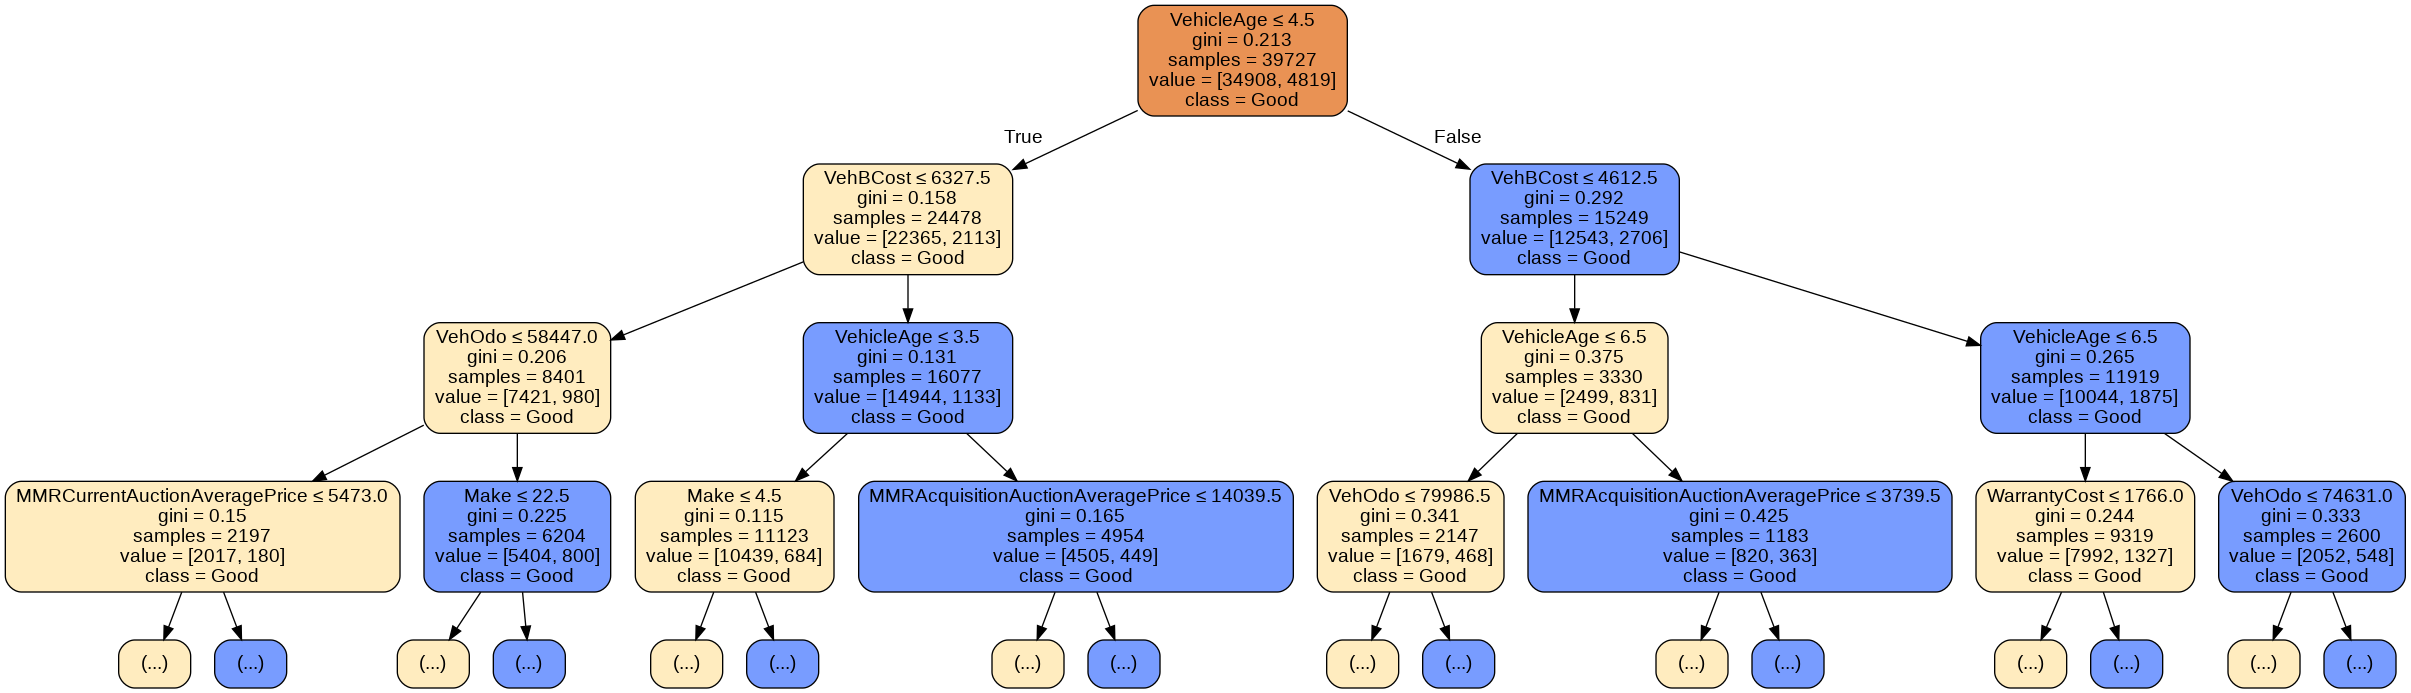

In [82]:
Image(graph.create_png())

### Analyze the classification performance

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

Evaluate the performance

In [106]:
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Train Accuracy 0.8795026052810431
Train F1-score [0.93581647 0.01724492]

Test Accuracy 0.8780101021966404
Test F1-score [0.93502268 0.00479157]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     14960
           1       0.24      0.00      0.00      2066

    accuracy                           0.88     17026
   macro avg       0.56      0.50      0.47     17026
weighted avg       0.80      0.88      0.82     17026



array([[14944,    16],
       [ 2061,     5]])

In [120]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)
print(roc_auc)

0.500675308405506
0.500675308405506


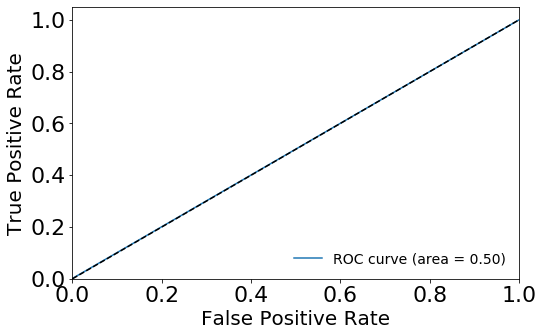

In [108]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

Cross Validation

In [0]:
from sklearn.model_selection import cross_val_score

In [110]:
scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.7890 (+/- 0.01)
F1-score: 0.5294 (+/- 0.01)


### Can we improve the performance using another classifier?

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
param_list = {'max_depth': [None] + list(np.arange(2, 50)),
              'min_samples_split': [2, 5, 10, 15, 20, 30, 50, 100, 150],
              'min_samples_leaf': [1, 5, 10, 15, 20, 30, 50, 100, 150],
              'criterion': ['gini', 'entropy'],
             }

clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                             min_samples_split=2, min_samples_leaf=1, class_weight=None)

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=100)
random_search.fit(X, y)
report(random_search.cv_results_, n_top=3)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 0.879 (std: 0.000)
Parameters: {'min_samples_split': 50, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'entropy'}

Model with rank: 1
Mean validation score: 0.879 (std: 0.000)
Parameters: {'min_samples_split': 100, 'min_samples_leaf': 20, 'max_depth': 24, 'criterion': 'entropy'}

Model with rank: 1
Mean validation score: 0.879 (std: 0.000)
Parameters: {'min_samples_split': 15, 'min_samples_leaf': 15, 'max_depth': 33, 'criterion': 'entropy'}



In [0]:
clf = random_search.best_estimator_

y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

In [0]:
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Train Accuracy 0.8787474513555013
Train F1-score [0.93545578 0.00124404]

Test Accuracy 0.8788323740162105
Test F1-score [0.93549698 0.00289995]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     14960
           1       1.00      0.00      0.00      2066

    accuracy                           0.88     17026
   macro avg       0.94      0.50      0.47     17026
weighted avg       0.89      0.88      0.82     17026



array([[14960,     0],
       [ 2063,     3]])

0.500675308405506


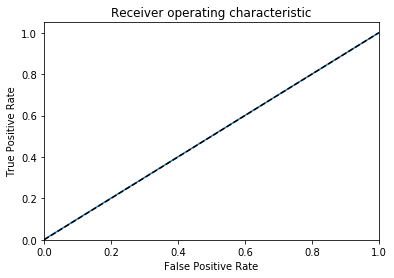

In [116]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

print( roc_auc_score(y_test, y_pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [0]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)
roc_auc

0.5007260406582769


0.5007260406582769

In [113]:
roc_auc

0.500675308405506

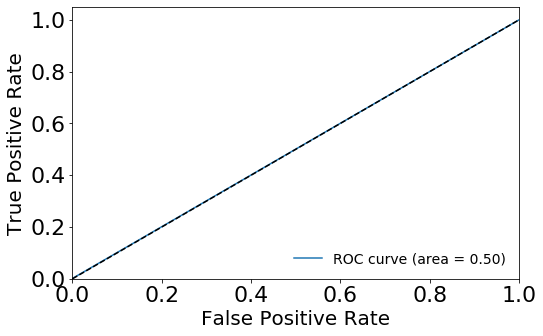

In [0]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [0]:
scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.8786 (+/- 0.00)


/Users/piyush2017/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/piyush2017/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/piyush2017/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-score: 0.4684 (+/- 0.00)


/Users/piyush2017/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
